In [27]:
import pandas as pd
from pathlib import Path
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Big picture

the dataset is gotten from [city of chicago website](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data)

It contains the daily rides train and bus rides in chicago

### iNGEST

In [3]:
path = Path("datasets/ridership_new/CTA_-_Ridership_-_Daily_Boarding_Totals_20240528.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


Rename the columns
Change "service_date" to "date"
Change "rail_boardings" to "rail"

In [4]:
df.rename(columns={
    "service_date": "date",
    "rail_boardings": "rail"
}, inplace=True)

In [5]:
# Sort by the date column -- and set use it as the index
df = df.sort_values("date").set_index("date")
df.shape
df.head()

(8522, 4)

,day_type,bus,rail,total_rides
date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343


In [6]:
# Are the dates unique???
df.index.is_unique

False

The dates are not unique. Check the duplicated dates

In [7]:
duplicated = df[df.index.duplicated(keep=False)]
duplicated.shape
duplicated.head(10)

(124, 4)

,day_type,bus,rail,total_rides
date,,,,
2011-10-01,A,701783,480889,1182672
2011-10-01,A,701783,480889,1182672
2011-10-02,U,486409,344520,830929
2011-10-02,U,486409,344520,830929
2011-10-03,W,1091676,751034,1842710
2011-10-03,W,1091676,751034,1842710
2011-10-04,W,1090878,767029,1857907
2011-10-04,W,1090878,767029,1857907
2011-10-05,W,1083300,774142,1857442


In [8]:
# Drop the duplicates
df.shape
df.drop_duplicates(keep='first', inplace=True)
df.shape

(8522, 4)

(8460, 4)

### EDA

In [9]:
# Drop the day type column for the sake of plotting
df = df.loc[:, ["bus", "rail"]]
df.head()

,bus,rail
date,,
2001-01-01,297192,126455
2001-01-02,780827,501952
2001-01-03,824923,536432
2001-01-04,870021,550011
2001-01-05,890426,557917


In [25]:
print(f"The date ranges from {df.index[0].strftime('%Y-%b-%d')} till {df.index[-1].strftime('%Y-%b-%d')}")

The date ranges from 2001-Jan-01 till 2024-Feb-29


In [23]:
df.index[0].strftime("%Y-%b-%d")

'2001-Jan-01'

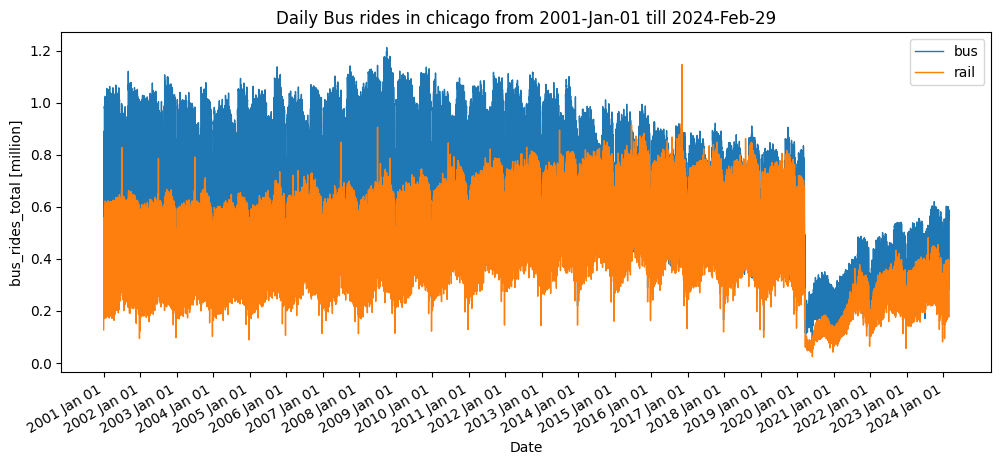

In [28]:
# Visualize the entire dataset as is
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df["bus"]/1e6, label="bus", linestyle="-", linewidth=1)
ax.plot(df["rail"]/1e6, label="rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Rides [million]")
ax.set_title(f"Daily Bus rides in chicago from {df.index[0].strftime('%Y-%b-%d')} till {df.index[-1].strftime('%Y-%b-%d')}")

plt.xticks(pd.date_range(start=df.index[0], end=df.index[-1], freq="YS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))

ax.legend()
fig.autofmt_xdate();

+ Nothing is visible -- There are too many datapoints
+ The trend seemed to have changed from 2020. This was during the pandemic
+ The data after 2020 seems to be in an uptrend. Trying to return back to normal
+ There is no doubt that the data beore 2020 is obsolete.

Task: Zoom in on the dataset from 2020 and beyond.

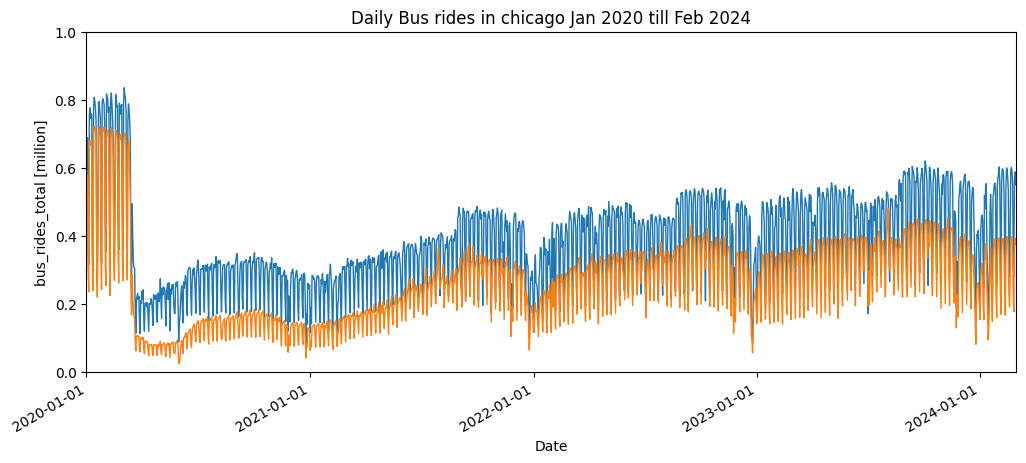

In [30]:
## Zoom in on the from 2020 - 2024
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df/1e6, linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Rides [million]")
ax.set_title("Daily Bus rides in chicago Jan 2020 till Feb 2024")

plt.xticks(pd.date_range(start=df.index[0], end=df.index[-1], freq="YS", inclusive='both'))

start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 2, 29)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)
plt.ylim(0, 1)

fig.autofmt_xdate()
plt.show();

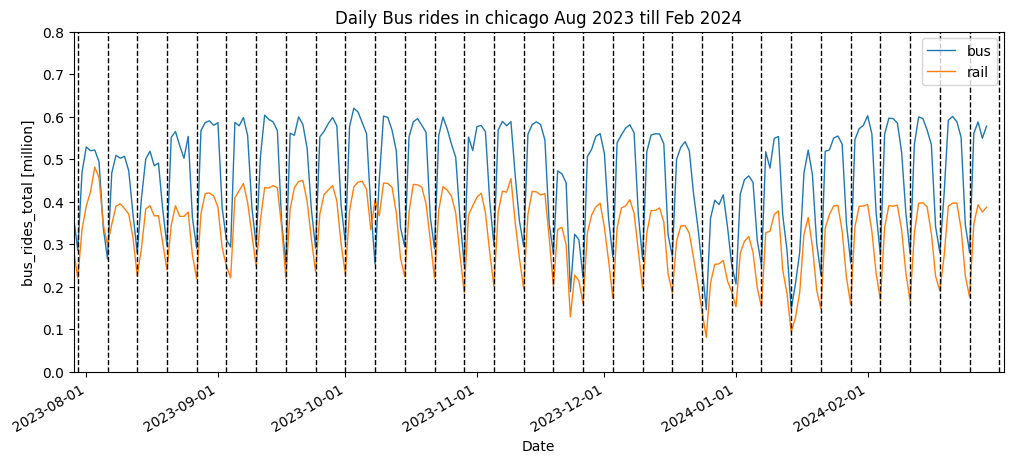

In [34]:
## Zoom in -- Check for seasonality
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df["bus"]/1e6, label="bus", linestyle="-", linewidth=1)
ax.plot(df["rail"]/1e6, label="rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Rides_total [million]")
ax.set_title("Daily rides in chicago Aug 2023 till Feb 2024")

plt.xticks(pd.date_range(start=df.index[0], end=df.index[-1], freq="MS", inclusive='both'))

start_date = datetime(2023, 7 ,29)
end_date = datetime(2024, 3, 4)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)
plt.ylim(0, 0.8)

for i in pd.date_range(start=start_date, end=end_date, freq="W", inclusive='both'):
            ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

ax.legend()
fig.autofmt_xdate()
plt.show();

The weekly seasonality is very strong.  

Let's resample the dataset

In [35]:
df.head()

,bus,rail
date,,
2001-01-01,297192,126455
2001-01-02,780827,501952
2001-01-03,824923,536432
2001-01-04,870021,550011
2001-01-05,890426,557917


In [36]:
period = slice("2004", "2024")
df_monthly = df.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

In [37]:
df_monthly.head()
df_monthly.tail()

,bus,rail
date,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065


,bus,rail
date,,
2023-10-31,491693.193548,371285.290323
2023-11-30,463167.733333,330680.800000
2023-12-31,429316.161290,282792.258065
2024-01-31,415582.741935,275880.096774
2024-02-29,496843.965517,320690.310345


In [38]:
rolling_average_12_months.head(13)

,bus,rail
date,,
2004-01-31,NaN,NaN
2004-02-29,NaN,NaN
2004-03-31,NaN,NaN
2004-04-30,NaN,NaN
2004-05-31,NaN,NaN
2004-06-30,NaN,NaN
2004-07-31,NaN,NaN
2004-08-31,NaN,NaN
2004-09-30,NaN,NaN


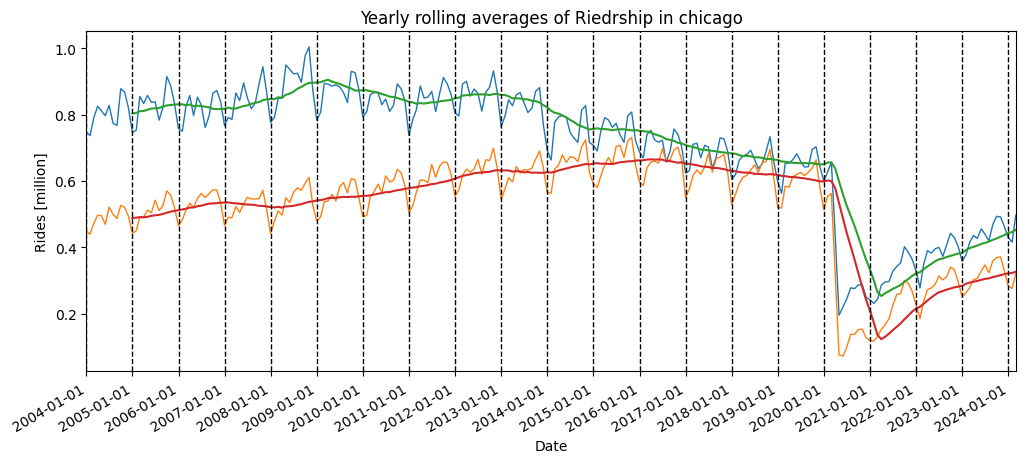

In [39]:
## Plot rolling average
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df_monthly/1e6, linestyle="-", linewidth=1)
ax.plot(rolling_average_12_months.loc[:, ["bus", "rail"]]/1e6)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Rides [million]")
ax.set_title("Yearly rolling averages of Riedrship in chicago")

plt.xticks(pd.date_range(start=df.index[0], end=df.index[-1], freq="YS", inclusive='both'))

start_date = datetime(2004,1, 1)
end_date = datetime(2024, 3, 4)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)

for i in pd.date_range(start=start_date, end=end_date, freq="YS", inclusive='both'):
            ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

fig.autofmt_xdate()
plt.show();

The goal is to predict daily ridership for an entire week.

The short term patterns should matter much less than the long term ones.  

However, i think we should be able to improve performance by taking long-term patterns into account

### Convert the ingestion process to a function

In [40]:
from pathlib import Path
import pandas as pd

def ingest_chicago_ridership():
    path = Path("datasets/ridership_new/CTA_-_Ridership_-_Daily_Boarding_Totals_20240528.csv")
    # read dataset
    df = pd.read_csv(path, parse_dates=["service_date"])
    # rename some columns
    df.rename(columns={
        "service_date": "date",
        "rail_boardings": "rail"
    }, inplace=True)
    # sort by date
    df = df.sort_values("date").set_index("date")
    # drop the duplicates
    df.drop_duplicates(keep='first', inplace=True)
    # index the data from 2020 till the end of the dataset
    df = df.loc["2020-1-1":]
    # the ferqunecy is daily
    df = df.asfreq("D")
    
    return df

In [41]:
df = ingest_chicago_ridership()
df.shape

(1521, 4)

In [42]:
df.head()
df.tail()

,day_type,bus,rail,total_rides
date,,,,
2020-01-01,U,267300,255759,523059
2020-01-02,W,651421,565139,1216560
2020-01-03,W,688165,578202,1266367
2020-01-04,A,409243,306656,715899
2020-01-05,U,314424,234155,548579


,day_type,bus,rail,total_rides
date,,,,
2024-02-25,U,280214,175446,455660
2024-02-26,W,560355,347691,908046
2024-02-27,W,587359,392420,979779
2024-02-28,W,549028,375242,924270
2024-02-29,W,577283,386672,963955


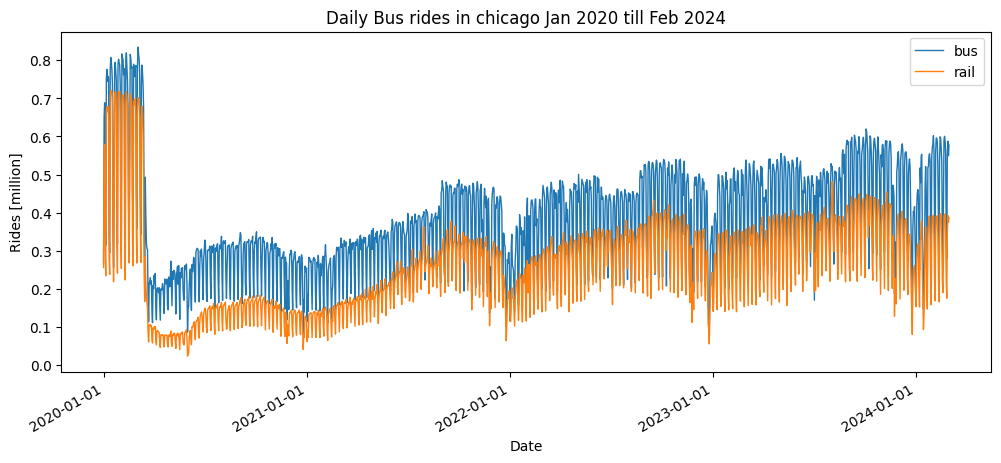

In [45]:
## confirm
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df["bus"]/1e6, label="bus", linestyle="-", linewidth=1)
ax.plot(df["rail"]/1e6, label="rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Rides [million]")
ax.set_title("Daily Bus rides in chicago Jan 2020 till Feb 2024")

plt.xticks(pd.date_range(start=df.index[0], end=df.index[-1], freq="YS", inclusive='both'))

ax.legend()
fig.autofmt_xdate()
plt.show();

### Test for stationarity

In [24]:
# Test for stationarity bus
ADF_result_bus = adfuller(df["bus"])
print(f'ADF Statistic for bus: {ADF_result_bus[0]}')
print(f'p-value: {ADF_result_bus[1]}')
print()
# Test for stationarity Rail
ADF_result_rail = adfuller(df["rail"])
print(f'ADF Statistic for rail: {ADF_result_rail[0]}')
print(f'p-value: {ADF_result_rail[1]}')

ADF Statistic for bus: -3.2845617247564816
p-value: 0.01558282834342694

ADF Statistic for rail: -3.3909097276838462
p-value: 0.011272689396411689


The p value is < 0.05  
Therefore we reject the null hypothesis and conclude tha the data is stationary

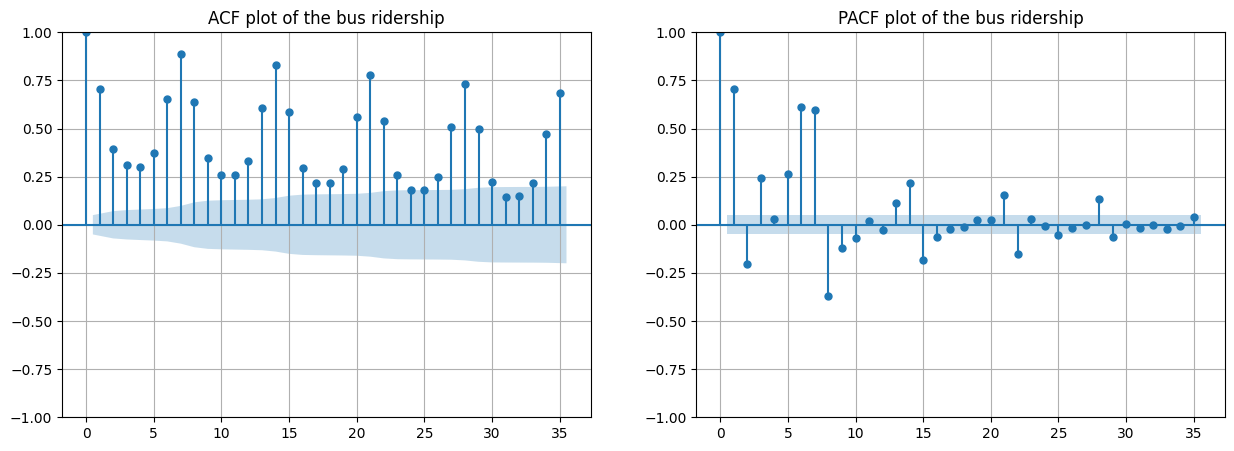

In [28]:
# Plot the Autocorrelation Function (ACF) and thePartial Autocorrelation Function (PACF)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df["bus"], ax=axs[0], lags=35, title="ACF plot of the bus ridership")
axs[0].grid()
plot_pacf(df["bus"], ax=axs[1], lags=35, method="ywm", title="PACF plot of the bus ridership")
axs[1].grid()
plt.show();

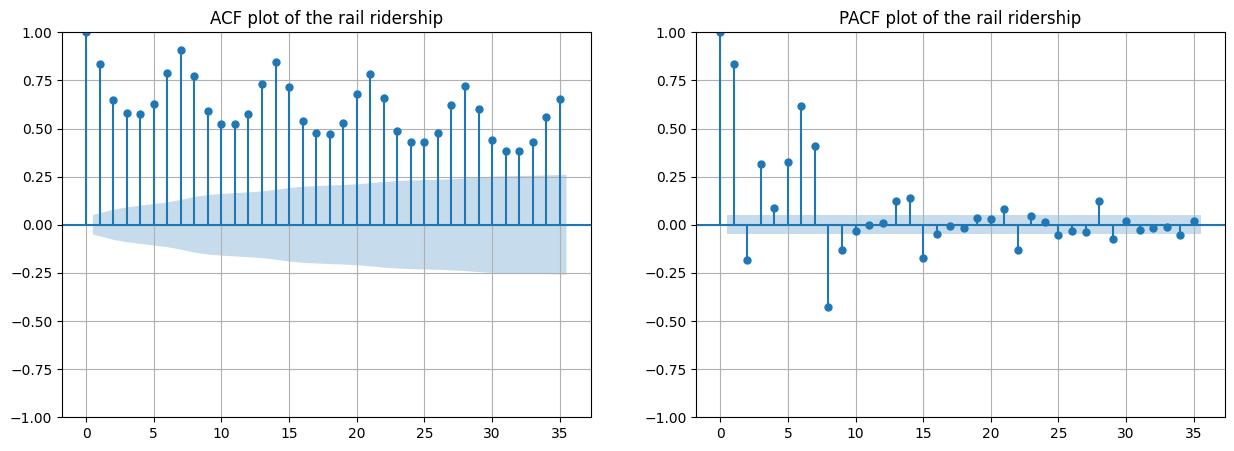

In [29]:
# Plot the Autocorrelation Function (ACF) and thePartial Autocorrelation Function (PACF)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df["rail"], ax=axs[0], lags=35, title="ACF plot of the rail ridership")
axs[0].grid()
plot_pacf(df["rail"], ax=axs[1], lags=35, method="ywm", title="PACF plot of the rail ridership")
axs[1].grid()
plt.show();

+ The present is correlated with past values. i.e They are not random walks
+ The coefficients are high, low, then high again. This is recurring. i.e There is a strong short term trend in the data
+ The data displays cyclical patterns i.e The data is seasonal

### Decomposition

In [47]:
# The data is daily and i see a strong weekly seasonality. so i set the period to 7
rail_decomposition = STL(df["rail"], period=7).fit()

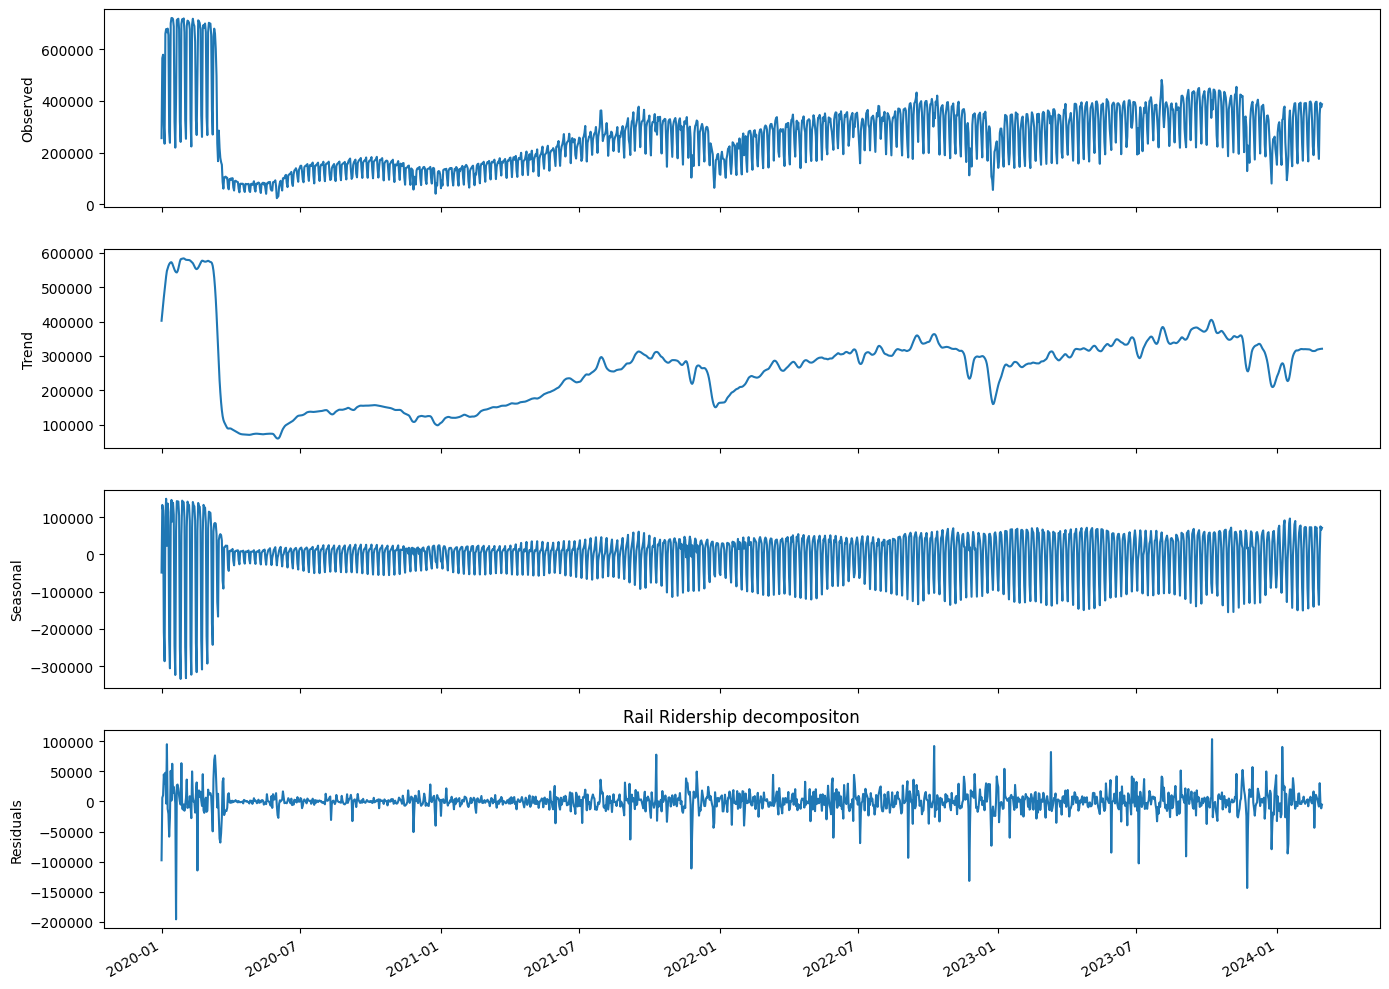

In [48]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

ax1.plot(rail_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(rail_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(rail_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(rail_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout();

The weekly seasonality is clear. 
The seasonality is starting to expand. i.e the peak of the trend is getting higher and the through is getting lower. 
The data is trying to come back to normal although we cannot know whether it will. The pandemic cahanged alot of things

In [32]:
# The data is daily and i see a strong weekly seasonality. so i set the period to 7
bus_decomposition = STL(df["bus"], period=7).fit()

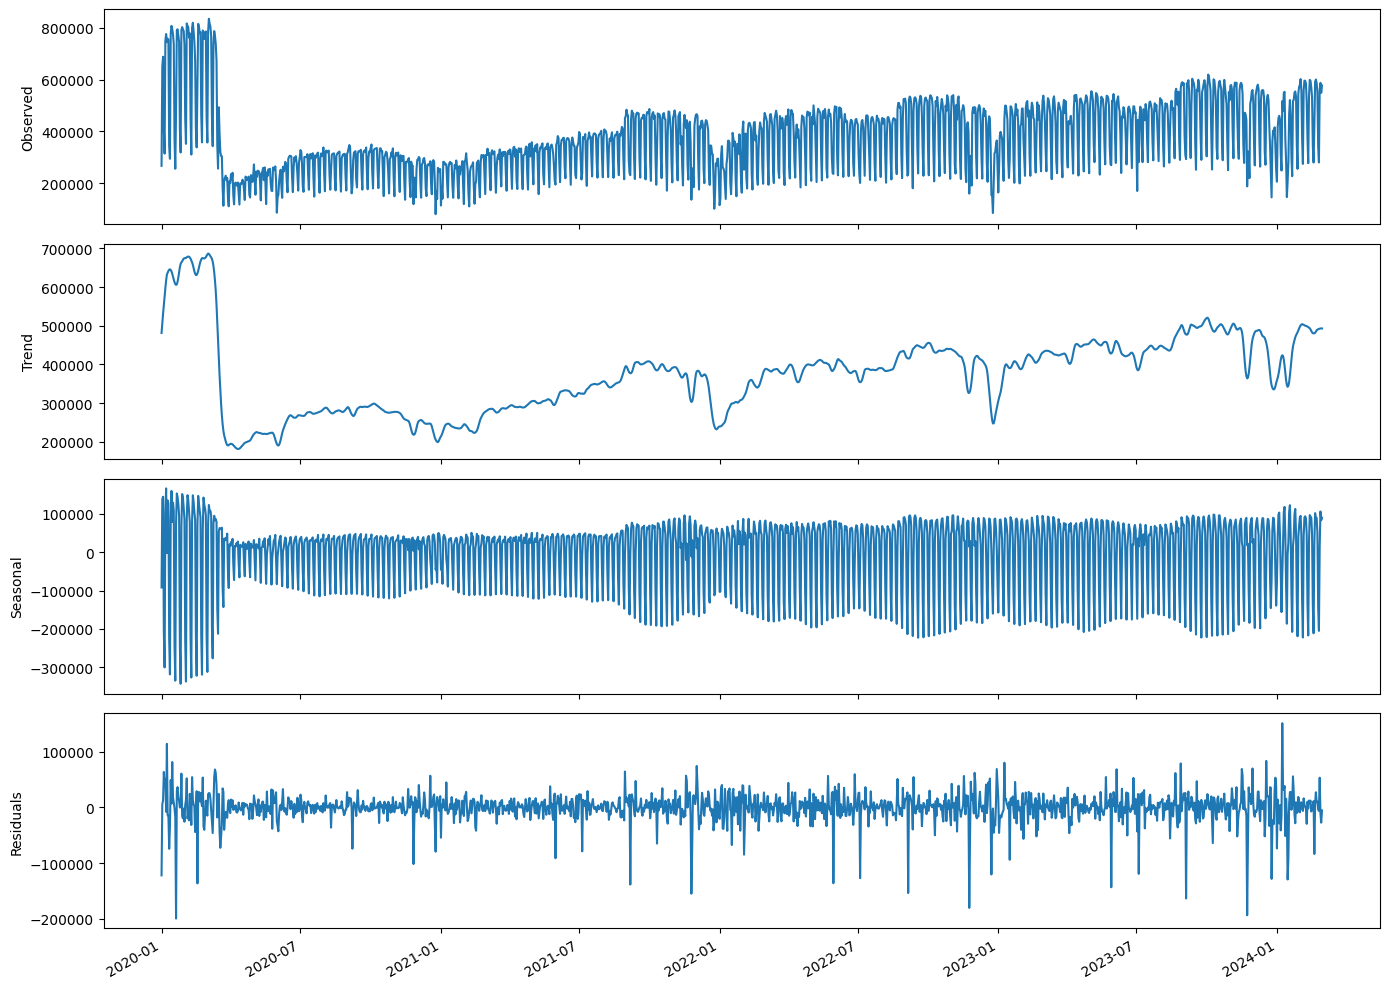

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

ax1.plot(bus_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(bus_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(bus_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(bus_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout();